## City district delineation using Graph Neural Networks

### Graph Neural Networks


Graph Neural Networks (GNNs) are a class of deep learning methods designed to perform inference on data described by graphs. GNNs are neural networks that can be directly applied to graphs, and provide an easy way to do node-level, edge-level, and graph-level prediction tasks. 

Anything that is composed of linked entities can be represented as a graph. Graphs are excellent tools to visualize relations between people, objects, and concepts. With graphs becoming more pervasive and richer with information, and artificial neural networks becoming more popular and capable, GNNs have become a powerful tool for many important applications.

<img src='GNN.png' width="600" height="600">

Graph neural networks can be created like any other neural network, using fully connected layers, convolutional layers, pooling layers, etc. The type and number of layers depend on the type and complexity of the graph data and the desired output. <br>
But unlike other architectures they run computational scheme directly over the input graph, treating its nodes as neurons and edges as synapses. This allows them to naturally account for the topology of the input network and unlike convolutional or recurrent neural networks they do not rely on any underlying geometry or sequential relations within the input data. The GNNs start with certain input features for each node and update those leveraging the network aggregation of the information from the connected nodes, applying a certain nonlinear activation function over it. This could be done recurrently in multiple iterations or using just a limited number of iterations. E.g. a state-of-the-art convolutional GNN architecture from [Kipf, Welling, 2016] ]uses just two iterations which can be implemented using a formulae $$ H^{(l+1)} = f(H^{(l)}, A) = \sigma ( H^{(l)}W_1^{(l)} + \hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}H^{(l)}W_2^{(l)}) $$


<img src='gnn2.jpeg' width="600" height="600">

The GNN receives the formatted graph data as input and produces a vector of numerical values that represent relevant information about nodes and their relations. This vector representation is called “graph embedding.”

One very popular GNN architecture is the graph convolutional neural network (GCN), which uses convolution layers to create graph embeddings. (Kipf, T.N. and Welling, M., 2016. Semi-supervised classification with graph convolutional networks. https://arxiv.org/pdf/1609.02907.pdf)

In the recent years, a lot of work has been done on the problem of generalizing neural networks to work on arbitrarily structured graphs - Bruna, J., Zaremba, W., Szlam, A. and LeCun, Y., 2013. Spectral networks and locally connected networks on graphs. https://arxiv.org/pdf/1312.6203.pdf%20http://arxiv.org/abs/1312.6203.pdf,  Henaff, M., Bruna, J. and LeCun, Y., 2015. Deep convolutional networks on graph-structured data. https://arxiv.org/abs/1506.05163 etc.

 
Few applications for graph neural networks:

- Node classification: One of the powerful applications of GNNs is adding new information to nodes or filling gaps where information is missing. For example, say you are running a social network and you have spotted a few bot accounts. Now you want to find out if there are other bot accounts in your network. You can train a GNN to classify other users in the social network as “bot” or “not bot” based on how close their graph embeddings are to those of the known bots.

- Edge prediction: Another way to put GNNs to use is to find new edges that can add value to the graph. Going back to our social network, a GNN can find users (nodes) who are close to you in embedding space but who aren’t your friends yet (i.e., there isn’t an edge connecting you to each other). These users can then be introduced to you as friend suggestions.

- Clustering: GNNs can glean new structural information from graphs. For example, in a social network where everyone is in one way or another related to others (through friends, or friends of friends, etc.), the GNN can find nodes that form clusters in the embedding space.

A comprehensive tutorial on GNNs by Stanford is available on Youtube: https://www.youtube.com/watch?v=JAB_plj2rbA&list=PLoROMvodv4rPLKxIpqhjhPgdQy7imNkDn

### Using basic ML classification models

Before applying an advanced GNN model, let’s see what the state-of-the-art machine learning classification models can do without accounting for the network connections using only the features of each node in the graph

In [14]:
import pandas as pd
import numpy as np
import networkx as nx

#Importing different classifier from sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore") 

seed = 433

#### Data overview

The LEHD mobility matrix contains the commute numbers between the home and work zip codes of the population. 'Weight' is the number of people traveling from origin to destination, and 'true_label' is the actual borough classification for a particular origin zip code.

In [4]:
data = pd.read_csv('data/zips_merged.csv', delimiter=',')
data = data.rename(columns={'total': 'weight', 'w_zip':'origin', 'h_zip':'destination'})
data = data[data.destination.isin(data.origin.unique())]
data = data[['origin', 'destination', 'weight', 'true_label']]
data.head()

,origin,destination,weight,true_label
0,11436,10009,1,4
1,11436,10011,1,4
2,11436,10013,1,4
3,11436,10019,1,4
4,11436,10021,1,4


In [5]:
# Add the house price feature into the dataset

housePrice = pd.read_csv('data/zipcode_housePrice.csv', delimiter=',')
weights = [5000,12500,17500,22500,27500,32500,37500,45000,55000,65000,75000,85000
                    ,95000,112500,137500,162500,187500,225000,275000,350000,450000,625000,875000
                        ,1250000,1750000,2000000]
for i in range(len(weights)):
    housePrice.iloc[i,2:] = housePrice.iloc[i,2:]*weights[i]
housePrice.iloc[:,1] [housePrice.iloc[:,1] == 0] = 1

tmp = (housePrice.iloc[:,2:] != 0 ).sum(axis=1)
tmp[tmp == 0] = 1
housePrice = pd.concat([housePrice.iloc[:,0],housePrice.iloc[:,2:].sum(axis=1) / tmp ], axis = 1 )
housePrice.rename(columns={'ZIPCODE':'destination', 0: 'house_price'}, inplace=True)
housePrice['house_price'] = housePrice['house_price']/housePrice['house_price'].sum()

In [6]:
# Add the area size feature into the dataset

area = pd.read_csv('data/zips_area.csv', delimiter=',')
area = area.iloc[:,:2]
area.rename(columns={'ZIPCODE':'destination', 'AREA' : 'area'}, inplace=True)
areas = area.copy()
area['area'] = area['area']/area['area'].sum()

In [7]:
# Add the income level feature into the dataset

income = pd.read_csv('data/zipcode_income.csv', delimiter=',')
income = income.iloc[:,:2]
income[income.isna()] = 0
income.rename(columns={'ZIPCODE':'destination', 'median_familyIncome(USD)' : 'income'}, inplace=True)
income['income'] = income['income']/income['income'].sum()

In [8]:
# Add the population jobs feature into the dataset

jobs = pd.read_csv('data/zipcode_population_Jobs.csv', delimiter=',')
jobs = jobs.iloc[:,:2]
jobs.rename(columns={'ZIPCODE':'destination', 'totalJobs' : 'jobs'}, inplace=True)
jobs['jobs'] = jobs['jobs'] / areas['area']

In [9]:
# Add the population feature into the dataset

population = pd.read_csv('data/zipcode_population_Jobs.csv', delimiter=',')
population = population[['ZIPCODE','POPULATION']]
population.rename(columns={'ZIPCODE':'destination', 'POPULATION' : 'population'}, inplace=True)
population['population'] = population['population'] / areas['area']

In [10]:
# merging all

data = data.merge(population)
data = data.merge(jobs)
data = data.merge(housePrice)
data = data.merge(area)
data = data.merge(income)

In [11]:
data

,origin,destination,weight,true_label,population,jobs,house_price,area,income
0,11436,10009,1,4,0.001283,0.000186,0.001633,0.001901,0.003724
1,11213,10009,14,3,0.001283,0.000186,0.001633,0.001901,0.003724
2,11212,10009,27,3,0.001283,0.000186,0.001633,0.001901,0.003724
3,11225,10009,26,3,0.001283,0.000186,0.001633,0.001901,0.003724
4,11218,10009,60,3,0.001283,0.000186,0.001633,0.001901,0.003724
...,...,...,...,...,...,...,...,...,...
36407,11211,11371,7,3,0.000000,0.000486,0.000000,0.003652,0.000000
36408,11373,11371,3,4,0.000000,0.000486,0.000000,0.003652,0.000000
36409,10168,11371,1,1,0.000000,0.000486,0.000000,0.003652,0.000000
36410,10278,11371,1,1,0.000000,0.000486,0.000000,0.003652,0.000000


In [15]:
# function for loading data, returns adjacency matrix, initial feature assignments and true labels

def load_data():

    G = nx.from_pandas_edgelist(data, 'origin', 'destination', 'weight',create_using=nx.DiGraph())
    adj_list = np.array([nx.adjacency_matrix(G).todense()], dtype=float)
    
    init_feat1 = np.array(data.groupby('origin')['population'].agg(['unique']))
    init_feat1 = np.array(list(map(lambda x: x[0][0], init_feat1))).reshape(-1, 1)
    init_feat2 = np.array(data.groupby('origin')['house_price'].agg(['unique']))
    init_feat2 = np.array(list(map(lambda x: x[0][0], init_feat2))).reshape(-1, 1)
    init_feat3 = np.array(data.groupby('origin')['area'].agg(['unique']))
    init_feat3 = np.array(list(map(lambda x: x[0][0], init_feat3))).reshape(-1, 1)
    init_feat4 = np.array(data.groupby('origin')['income'].agg(['unique']))
    init_feat4 = np.array(list(map(lambda x: x[0][0], init_feat4))).reshape(-1, 1)
    init_feat5 = np.array(data.groupby('origin')['jobs'].agg(['unique']))
    init_feat5 = np.array(list(map(lambda x: x[0][0], init_feat5))).reshape(-1, 1)
    
    init_feat = np.concatenate([init_feat1,init_feat2,init_feat3,init_feat4,init_feat5],axis=1)
    
    true_label = np.array(data.groupby('origin')['true_label'].agg(['unique']))
    
    true_label = np.array(list(map(lambda x: x[0][0], true_label))).reshape(-1, 1)
    return adj_list,init_feat,true_label

adj,feature,labels = load_data()

features = np.expand_dims(feature, axis=0)


In [16]:
# Splitting the features and label into Training and Validation Set

X_train, X_test, y_train, y_test = train_test_split(feature, labels, test_size = 0.2, random_state = seed)

In [17]:
# Define scoring method
scoring = 'accuracy'

# Baseline Model building to train
names = ['K Nearest Neighbors', 'Gaussian Process', 'Decision Tree', 'Random Forest', 'Neural Net',
         'AddaBoost', 'Naive Bayes', 'SVM Linear', 'SVM Sigmoid']
Classifiers = [
    KNeighborsClassifier(n_neighbors = 3),
    GaussianProcessClassifier(1.0*RBF(1.0)),
    DecisionTreeClassifier(max_depth = 5),
    RandomForestClassifier(max_depth = 5, n_estimators = 10, max_features = 1 ),
    MLPClassifier(alpha = 1),
    AdaBoostClassifier(),
    GaussianNB(),
    svm.SVC(kernel = 'linear'),
    svm.SVC(kernel = 'sigmoid')
    
    ]
models = zip(names, Classifiers)

# Train each model on our dataset and look at the accuracy

for name, model in models:
    
    model.fit(X_train,y_train)
    train_acc = accuracy_score(y_train,model.predict(X_train))
    val_acc = accuracy_score(y_test,model.predict(X_test))
    
    msg = "{0}:\nTraining Accuracy : {1} Validation Accuracy : {2}\n\n".format(name, train_acc, val_acc)
    print(msg)



K Nearest Neighbors:
Training Accuracy : 0.3614457831325301 Validation Accuracy : 0.30952380952380953


Gaussian Process:
Training Accuracy : 0.3614457831325301 Validation Accuracy : 0.3333333333333333


Decision Tree:
Training Accuracy : 0.3614457831325301 Validation Accuracy : 0.3333333333333333


Random Forest:
Training Accuracy : 0.3614457831325301 Validation Accuracy : 0.3333333333333333


Neural Net:
Training Accuracy : 0.3313253012048193 Validation Accuracy : 0.30952380952380953


AddaBoost:
Training Accuracy : 0.3614457831325301 Validation Accuracy : 0.3333333333333333


Naive Bayes:
Training Accuracy : 0.3614457831325301 Validation Accuracy : 0.3333333333333333


SVM Linear:
Training Accuracy : 0.3313253012048193 Validation Accuracy : 0.30952380952380953


SVM Sigmoid:
Training Accuracy : 0.3313253012048193 Validation Accuracy : 0.30952380952380953




For complex dataset such as graphs with interconnected nodes, as expected, it is difficult to infer the boundaries of the city boroughs using just the features of each of the nodes. As a result we see that even the state of the art classic machine learning classification algorithms accuracy is only slightly above one-thirds of our dataset. <br> Therefore, we need to account for the connectivity between the nodes as well as the features. This is where the GNNs come in

### GNN for city delineation

Here, we demonstrate an application for GNN for city borough delineation. We shall consider an LEHD commute network as an input, where the zip code locations across the city are the nodes, while the edges between them are weighted by the number of commuters between the two locations. The input features for the nodes include available socio-economic characteristics of those areas, such as population and job density, average income per capita etc (detail if there are any other input features). And the objective for the GNN will be to learn the borough attachment labels for each zip code location. The training will be performed in a supervised matter, making the model learn to match the known borough attachment of the certain part of the locations (training data) and then evaluating its performance over the rest of the locations (test data).

In [2]:
# import packages

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
torch.set_printoptions(sci_mode=False)
import time

In [12]:
# set initial model config

cuda = torch.cuda.is_available()
weight_decay = 1e-8
epochs = 10000
seed = 635
hidden = 16
lr = 0.0001

In [13]:
np.random.seed(seed)
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

We use a symmetric normalization for the propogating the layer, i.e. $$D^{−1/2}AD^{−1/2} $$

In [14]:
def normalize(adj):

    adj = torch.FloatTensor(adj)
    adj_id = torch.FloatTensor(torch.eye(adj.shape[1]))
    adj_id = adj_id.reshape((1, adj.shape[1], adj.shape[1]))
    adj_id = adj_id.repeat(adj.shape[0], 1, 1)
    adj = adj + adj_id
    rowsum = torch.FloatTensor(adj.sum(2))
    degree_mat_inv_sqrt = torch.diag_embed(torch.float_power(rowsum,-0.5), dim1=-2, dim2=-1).float()
    adj_norm = torch.bmm(torch.transpose(torch.bmm(adj,degree_mat_inv_sqrt),1,2),degree_mat_inv_sqrt)

    return adj_norm


The activation function for the GNN is the double ReLU which is linear between between 0 and 1

In [15]:
def doublerelu(x):
    return torch.clamp(x, 0, 1)

The Layer propogation rule of the GNN is : $$ H^{(l+1)} = f(H^{(l)}, A) = \sigma ( H^{(l)}W_1^{(l)} + \hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}H^{(l)}W_2^{(l)}) $$

where H is the l'th neural network layer, A is the adjaceny matrix, D is the diagonal node degree matrix, W1 , W2 are learnable weight matrices initialised as W1 = 1, W2 = 0  and sigma is the activation function doublerelu.

In [16]:
class GNN1Layer(Module):

    def __init__(self, batch_size, in_features, out_features, first):
        super(GNN1Layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.batch_size = batch_size
        
        # Initialse W1 = 1, W2 = 0 as pytorch learnable weights (parameters) that have require_grad = True which is
        # required for calculating gradients while backpropogating using gradient descent
        weight1_eye = torch.FloatTensor(torch.eye(in_features, out_features))
        weight1_eye = weight1_eye.reshape((1, in_features, out_features))
        weight1_eye = weight1_eye.repeat(batch_size, 1, 1)
        self.weight1 = Parameter(weight1_eye)
        if not first:
            self.weight2 = Parameter(torch.zeros(batch_size, in_features, out_features))
        else:
            self.weight2 = Parameter(torch.empty(batch_size, in_features, out_features))
            nn.init.kaiming_normal_(self.weight2, mode='fan_out')

    def forward(self, input, adj):
        # first term H*W1
        v1 = torch.bmm(input, self.weight1)
        # second term adj_norm*H*W2
        v2 = torch.bmm(torch.bmm(adj, input), self.weight2)
        # adding the two terms
        output = v1 + v2

        return output

In [17]:
class GNN1(nn.Module):

    def __init__(self, batch_size, nfeat, ndim, hidden, first):
        super(GNN1, self).__init__()

        self.gc1 = GNN1Layer(batch_size, nfeat, hidden, first)
        self.gc2 = GNN1Layer(batch_size, hidden, ndim, first)

    def forward(self, x, adj):

        # Applying activation function sigma (doublerelu) on the layer propogation
        x = doublerelu(self.gc1(x, adj))
        x = doublerelu(self.gc2(x, adj))
        x = x/x.sum(axis=2).unsqueeze(2) #normalize st sum = 1
        
        return x

In [18]:
def train(adj,features,labels,train_indices,val_indices,first=False):
    
    # calculate symmetric normalisation for layer propogation
    adj_norm = normalize(adj)
    
    labels = labels - 1
    
    # Convert from numpy to torch tensors
    adj = torch.FloatTensor(adj)
    adj_norm = torch.FloatTensor(adj_norm)
    features = torch.FloatTensor(features)
    labels = torch.FloatTensor(labels)
    
    # initialise the model
    model = GNN1(batch_size=adj.shape[0],
                nfeat=features.shape[-1],
                ndim=5,
                hidden=hidden,
                first=first)
    
    # Transfer the weights to GPU for training
    if cuda:
        model.cuda()
        features = features.cuda()
        adj = adj.cuda()
        adj_norm = adj_norm.cuda()
        labels = labels.cuda()
    
    # Train model
    t_total = time.time()

    # Using adam optimizers for backpropogation
    optimizer = optim.Adam(model.parameters(),
                           lr=lr, weight_decay=weight_decay)
    
    # loss function criteria is cross entropy loss
    criterion = nn.CrossEntropyLoss()
    
    # Train for the no of epochs
    for epoch in range(epochs):

        t = time.time()
        
        model.train()
        
        # Pytorch accumulates gradient after every operation on tensors (defined by the model architecture)
        # with require_grad = True. With each new epoch, we need to reset this gradient to 0 to calculate gradient
        # for this epoch.
        optimizer.zero_grad()

        # get the output from forward propogation of our model
        output = model(features, adj_norm)
        
        # Calculate Train accuracy
        train_output = output[:,train_indices,:]
        train_labels = labels[train_indices,:]
        train_accuracy = torch.sum(torch.argmax(train_output,axis=2)==train_labels.reshape(1,-1))/train_labels.shape[0]
        
        # Calculate the loss between our models training output and true label
        loss = criterion(output[0],labels.reshape(-1).long())
        
        # Calculate the gradients 
        loss.backward(retain_graph=True)

        # Update the weights
        optimizer.step()
        
        model.eval()
        
        # Calculate Validation accuracy
        with torch.no_grad():
            val_output = output[:,val_indices,:]
            val_labels = labels[val_indices,:]
            val_accuracy = torch.sum(torch.argmax(val_output,axis=2)==val_labels.reshape(1,-1))/val_labels.shape[0]

        # Print summary of training 
        if epoch == 0:
            best_loss = loss
            best_output = output
            best_acc = train_accuracy
            best_val_acc = val_accuracy
            best_val_output = val_output
        else:
            if loss < best_loss:
                best_loss = loss
                best_output = output
                best_acc = train_accuracy
                best_val_acc = val_accuracy
                best_val_output = val_output

        if epoch == 0 or (epoch+1) % 1000 == 0:
            print('Epoch: {:04d}'.format(epoch + 1),
                  'Train Accuracy: {:.4f}'.format(best_acc.item()),
                  'Validation Accuracy: {:.4f}'.format(best_val_acc.item()),
                  'Loss: {:.8f}'.format(best_loss.item()),
                  'time: {:.4f}s'.format(time.time() - t))
            
    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    
    return best_loss,best_output#,best_val_output

In [21]:
# set Train %

train_percentage = .8
    
# Train set
number_of_rows = features[0].shape[0]
train_indices = np.random.choice(number_of_rows, size=int(train_percentage*number_of_rows), replace=False)
val_indices = np.setdiff1d(np.arange(adj.shape[1]),train_indices)

# Start Train
prev_loss, op = train(adj,features,labels,train_indices,val_indices,True)

# Keep training recurrently until the loss stops decreasing
loss, op = train(adj,op.cpu().detach().numpy(),labels,train_indices,val_indices)
while loss < prev_loss :
    prev_loss = loss
    loss, op = train(adj,op.cpu().detach().numpy(),labels,train_indices,val_indices)

Epoch: 0001 Train Accuracy: 0.2349 Validation Accuracy: 0.2143 Loss: 1.65001929 time: 0.0877s
Epoch: 1000 Train Accuracy: 0.3373 Validation Accuracy: 0.1905 Loss: 1.57184041 time: 0.0009s
Epoch: 2000 Train Accuracy: 0.3434 Validation Accuracy: 0.1905 Loss: 1.56879020 time: 0.0008s
Epoch: 3000 Train Accuracy: 0.3494 Validation Accuracy: 0.1905 Loss: 1.56441104 time: 0.0013s
Epoch: 4000 Train Accuracy: 0.3494 Validation Accuracy: 0.1905 Loss: 1.55421937 time: 0.0008s
Epoch: 5000 Train Accuracy: 0.3494 Validation Accuracy: 0.1905 Loss: 1.55066097 time: 0.0017s
Epoch: 6000 Train Accuracy: 0.3373 Validation Accuracy: 0.1905 Loss: 1.54898024 time: 0.0008s
Epoch: 7000 Train Accuracy: 0.3373 Validation Accuracy: 0.1905 Loss: 1.54898024 time: 0.0009s
Epoch: 8000 Train Accuracy: 0.3373 Validation Accuracy: 0.1905 Loss: 1.54898024 time: 0.0008s
Epoch: 9000 Train Accuracy: 0.3373 Validation Accuracy: 0.1905 Loss: 1.54898024 time: 0.0012s
Epoch: 10000 Train Accuracy: 0.3373 Validation Accuracy: 0.1

Epoch: 7000 Train Accuracy: 0.7289 Validation Accuracy: 0.7381 Loss: 1.17395997 time: 0.0009s
Epoch: 8000 Train Accuracy: 0.7289 Validation Accuracy: 0.7381 Loss: 1.17395997 time: 0.0008s
Epoch: 9000 Train Accuracy: 0.7289 Validation Accuracy: 0.7381 Loss: 1.17395997 time: 0.0008s
Epoch: 10000 Train Accuracy: 0.7289 Validation Accuracy: 0.7381 Loss: 1.17395997 time: 0.0008s
Optimization Finished!
Total time elapsed: 9.1584s
Epoch: 0001 Train Accuracy: 0.7289 Validation Accuracy: 0.7381 Loss: 1.17395997 time: 0.0010s
Epoch: 1000 Train Accuracy: 0.7289 Validation Accuracy: 0.7381 Loss: 1.17322230 time: 0.0009s
Epoch: 2000 Train Accuracy: 0.7349 Validation Accuracy: 0.7381 Loss: 1.17114902 time: 0.0009s
Epoch: 3000 Train Accuracy: 0.7349 Validation Accuracy: 0.7381 Loss: 1.17114902 time: 0.0010s
Epoch: 4000 Train Accuracy: 0.7349 Validation Accuracy: 0.7381 Loss: 1.17114902 time: 0.0008s
Epoch: 5000 Train Accuracy: 0.7349 Validation Accuracy: 0.7381 Loss: 1.17114902 time: 0.0008s
Epoch: 6

Epoch: 2000 Train Accuracy: 0.7590 Validation Accuracy: 0.7381 Loss: 1.14852595 time: 0.0008s
Epoch: 3000 Train Accuracy: 0.7590 Validation Accuracy: 0.7381 Loss: 1.14845443 time: 0.0008s
Epoch: 4000 Train Accuracy: 0.7590 Validation Accuracy: 0.7381 Loss: 1.14833832 time: 0.0008s
Epoch: 5000 Train Accuracy: 0.7590 Validation Accuracy: 0.7381 Loss: 1.14813566 time: 0.0008s
Epoch: 6000 Train Accuracy: 0.7590 Validation Accuracy: 0.7381 Loss: 1.14813566 time: 0.0008s
Epoch: 7000 Train Accuracy: 0.7590 Validation Accuracy: 0.7381 Loss: 1.14813566 time: 0.0009s
Epoch: 8000 Train Accuracy: 0.7590 Validation Accuracy: 0.7381 Loss: 1.14813566 time: 0.0008s
Epoch: 9000 Train Accuracy: 0.7590 Validation Accuracy: 0.7381 Loss: 1.14813566 time: 0.0009s
Epoch: 10000 Train Accuracy: 0.7590 Validation Accuracy: 0.7381 Loss: 1.14813566 time: 0.0009s
Optimization Finished!
Total time elapsed: 8.6434s
Epoch: 0001 Train Accuracy: 0.7590 Validation Accuracy: 0.7381 Loss: 1.14813566 time: 0.0011s
Epoch: 1

Epoch: 9000 Train Accuracy: 0.7651 Validation Accuracy: 0.7381 Loss: 1.14175296 time: 0.0008s
Epoch: 10000 Train Accuracy: 0.7651 Validation Accuracy: 0.7381 Loss: 1.14175296 time: 0.0008s
Optimization Finished!
Total time elapsed: 8.5942s
Epoch: 0001 Train Accuracy: 0.7651 Validation Accuracy: 0.7381 Loss: 1.14175296 time: 0.0010s
Epoch: 1000 Train Accuracy: 0.7711 Validation Accuracy: 0.7381 Loss: 1.14137948 time: 0.0011s
Epoch: 2000 Train Accuracy: 0.7711 Validation Accuracy: 0.7381 Loss: 1.14106011 time: 0.0009s
Epoch: 3000 Train Accuracy: 0.7711 Validation Accuracy: 0.7381 Loss: 1.14075005 time: 0.0008s
Epoch: 4000 Train Accuracy: 0.7711 Validation Accuracy: 0.7381 Loss: 1.14054370 time: 0.0012s
Epoch: 5000 Train Accuracy: 0.7711 Validation Accuracy: 0.7381 Loss: 1.14039004 time: 0.0008s
Epoch: 6000 Train Accuracy: 0.7711 Validation Accuracy: 0.7381 Loss: 1.14028835 time: 0.0009s
Epoch: 7000 Train Accuracy: 0.7711 Validation Accuracy: 0.7381 Loss: 1.14022088 time: 0.0008s
Epoch: 8

In [22]:
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

Text(0.5, 1.0, 'predictions for test zipcodes')

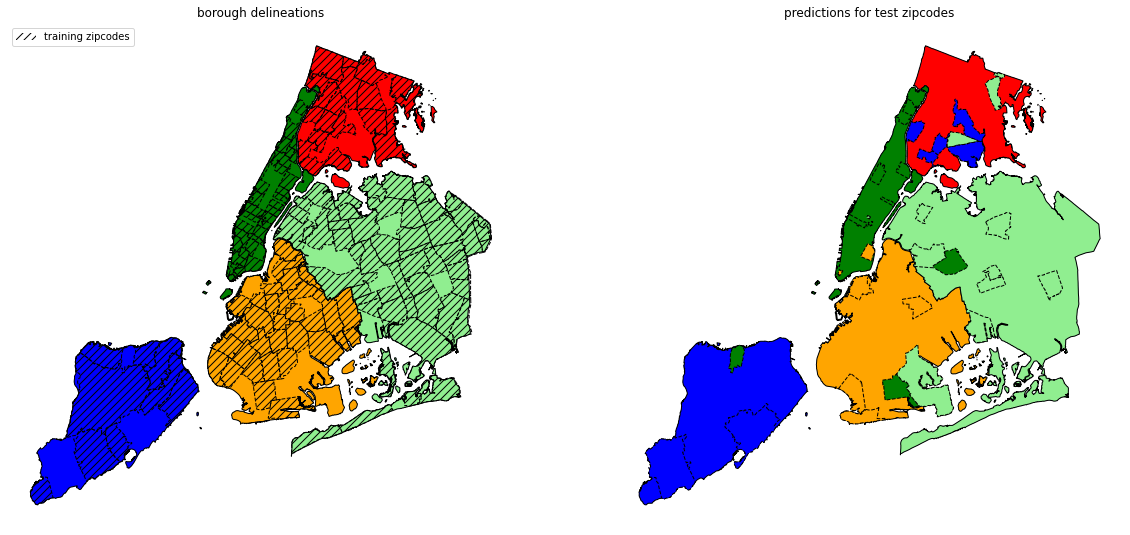

In [23]:
# visualization

# load zip code shapefile
zips = gpd.read_file('/Users/devashishkhulbe/Desktop/teaching/Labs_and_solutions/Data/zip_code/ZIP_CODE_040114.shp')
zips['ZIPCODE'] = pd.to_numeric(zips['ZIPCODE'])
zips = zips.to_crs(epsg=4326)

# get unique zipcodes from LEHD data and merge with above shapefile
zipsAll = data.groupby(by='origin', as_index=False).sum()
zipsAll = zipsAll.merge(zips, left_on='origin', right_on='ZIPCODE')
zipsAll.drop_duplicates(subset=['origin'], inplace=True)
zipsAll.reset_index(drop=True, inplace=True)
zipsAll = gpd.GeoDataFrame(zipsAll, crs="EPSG:4326", geometry='geometry')

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,12))

# first plot
# borough shapefile
boro = gpd.read_file('/Users/devashishkhulbe/Desktop/research/HGNN/Borough Boundaries.zip')
boro.plot(figsize=(10,10), ax=ax[0])

colors = ['r', 'g', 'b', 'orange', 'lightgreen']

# plot boroughs
for ind, b in enumerate(boro.boro_code):
    boro[boro.boro_code == b].plot(color=colors[ind], edgecolor="black", ax=ax[0])
    
# plot training zips
zipsTrain = zipsAll[zipsAll.index.isin(train_indices)][['origin', 'geometry']]

zipsTrain.plot(facecolor='None', hatch='///', edgecolor="black", linestyle='--', ax=ax[0], label='train zipcodes')
    
LegendElement = [mpatches.Patch(facecolor='None', hatch='///', label='training zipcodes')]
    

ax[0].axis('off')
ax[0].legend(handles = LegendElement, loc='upper left')
ax[0].set_title('borough delineations')


# second plot
# plot boroughs
boro.plot(figsize=(10,10), ax=ax[1])

colors = ['r', 'g', 'b', 'orange', 'lightgreen']
# colors = ['g', 'r', 'orange', 'lightgreen', 'b']

for ind, b in enumerate(boro.boro_code):
    boro[boro.boro_code == b].plot(color=colors[ind], edgecolor="black", ax=ax[1])
    
zipsVal = zipsAll[zipsAll.index.isin(val_indices)][['origin', 'geometry']]

# get predictions for masked zips
pred = torch.argmax(op[0], dim=1).numpy()+1
zipsVal['pred'] = pred[np.sort(val_indices)]

# plot masked zips
for p in zipsVal.pred.unique():
    zipsVal[zipsVal.pred == p].plot(color=colors[p], edgecolor="black", linestyle='--', ax=ax[1])
    
ax[1].axis('off')
ax[1].set_title('predictions for test zipcodes')

### Pytorch Basics can be found here:

#### Introduction to Pytorch Tensors : https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
#### Calculating gradients using Autograd : https://pytorch.org/tutorials/beginner/introyt/autogradyt_tutorial.html
#### Building Pytorch Models : https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html
#### Training Pytorch Models : https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
